<a href="https://colab.research.google.com/github/ArthAgrawal/Audio-Forensics-Research/blob/main/Audio_Forensics_Transformer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files
import cv2


In [ ]:
# Define paths to your directories
audio_folder = '/content/drive/MyDrive/ASVspoof2017_V2_train/'
text_file_path = '/content/drive/MyDrive/ASVspoof2017_V2_train.trn.txt'
real_folder = '/content/drive/MyDrive/asvpoof_data/real'
fake_folder = '/content/drive/MyDrive/asvpoof_data/fake'

In [ ]:
# Function to convert audio to Mel spectrogram
def audio_to_mel_spectrogram(file_path, sr=16000, n_mels=128, max_time_frames=128):
    try:
        y, original_sr = librosa.load(file_path, sr=sr)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Truncate or pad the spectrogram
        if mel_spectrogram.shape[1] > max_time_frames:
            mel_spectrogram = mel_spectrogram[:, :max_time_frames]
        else:
            pad_width = max_time_frames - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')

        return mel_spectrogram
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

In [ ]:
# Function to load data from folders
def load_data_from_folders(folders, labels, sr=16000, n_mels=128, max_time_frames=128):
    X, y = [], []
    for folder, label in zip(folders, labels):
        print(f"Processing {folder}...")
        for file in tqdm(os.listdir(folder)):
            file_path = os.path.join(folder, file)
            mel_spectrogram = audio_to_mel_spectrogram(file_path, sr, n_mels, max_time_frames)
            if mel_spectrogram is not None:
                X.append(mel_spectrogram)
                y.append(label)
    return np.array(X), np.array(y)

In [ ]:
# Load data
folders = [real_folder, fake_folder]
labels = [0, 1]  # Real=0, Fake=1
X, y = load_data_from_folders(folders, labels)

print(f"Loaded {len(X)} samples (Real=0, Fake=1).")
print(f"Shape of feature data: {X.shape}, Shape of labels: {y.shape}")

# Normalize the data
X_resized_flat = X.reshape((X.shape[0], -1))
scaler = MinMaxScaler()
X_normalized_flat = scaler.fit_transform(X_resized_flat)
X_normalized = X_normalized_flat.reshape(X.shape)

# Train test split
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Reshape for CNN input
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Final input shape (for CNN): {X_train.shape}")

Processing /content/drive/MyDrive/asvpoof_data/real...


100%|██████████| 1507/1507 [00:26<00:00, 56.15it/s]


Processing /content/drive/MyDrive/asvpoof_data/fake...


100%|██████████| 1507/1507 [00:26<00:00, 57.47it/s]


Loaded 3014 samples (Real=0, Fake=1).
Shape of feature data: (3014, 128, 128), Shape of labels: (3014,)
Training set shape: (2109, 128, 128), (2109,)
Validation set shape: (452, 128, 128), (452,)
Test set shape: (453, 128, 128), (453,)
Final input shape (for CNN): (2109, 128, 128, 1)


In [ ]:
# CNN feature extractor
def cnn_feature_extractor(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers for feature extraction
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten the output from CNN
    x = layers.GlobalAveragePooling2D()(x)

    return models.Model(inputs, x)

# Transformer model
def transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # CNN feature extraction part
    cnn_features = cnn_feature_extractor(input_shape)(inputs)

    # Add Transformer layers
    transformer_input = layers.Reshape((-1, cnn_features.shape[-1]))(cnn_features)

    transformer_block = layers.MultiHeadAttention(num_heads=4, key_dim=64)(transformer_input, transformer_input)
    transformer_block = layers.Dropout(0.1)(transformer_block)
    transformer_block = layers.LayerNormalization()(transformer_block)

    transformer_block = layers.GlobalAveragePooling1D()(transformer_block)

    # Fully connected layers
    x = layers.Dense(128, activation='relu')(transformer_block)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

# Build the transformer model
model = transformer_model((128, 128, 1))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 128)            │         93,568 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 128)         │              0 │ functional_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 1, 128)         │        131,968 │ reshape_2[0][0],       │
│ (MultiHeadAttention)      │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 1, 128)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1, 128)         │            256 │ dropout_9[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ layer_normalization_2… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64)             │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │             65 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 250,625 (979.00 KB)

 Trainable params: 250,177 (977.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.5438 - loss: 0.7668 - val_accuracy: 0.4989 - val_loss: 1.1125 - learning_rate: 0.0010
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7721 - loss: 0.4573 - val_accuracy: 0.4989 - val_loss: 2.5866 - learning_rate: 0.0010
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9285 - loss: 0.2053 - val_accuracy: 0.4989 - val_loss: 3.6526 - learning_rate: 0.0010
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9377 - loss: 0.1925 - val_accuracy: 0.7263 - val_loss: 1.1662 - learning_rate: 0.0010
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9696 - loss: 0.0985 - val_accuracy: 0.7660 - val_loss: 1.1751 - learning_rate: 0.0010
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9672 - loss: 0.0905 - val_accuracy: 0.9294 - val_loss: 0.2252 - learning_rate: 0.0010
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9823 - loss: 0.0580 - val_accuracy: 0.6

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Final Accuracy of the model: {test_accuracy * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3448e-04
Test Loss: 0.0007, Test Accuracy: 1.0000
Final Accuracy of the model: 100.00%


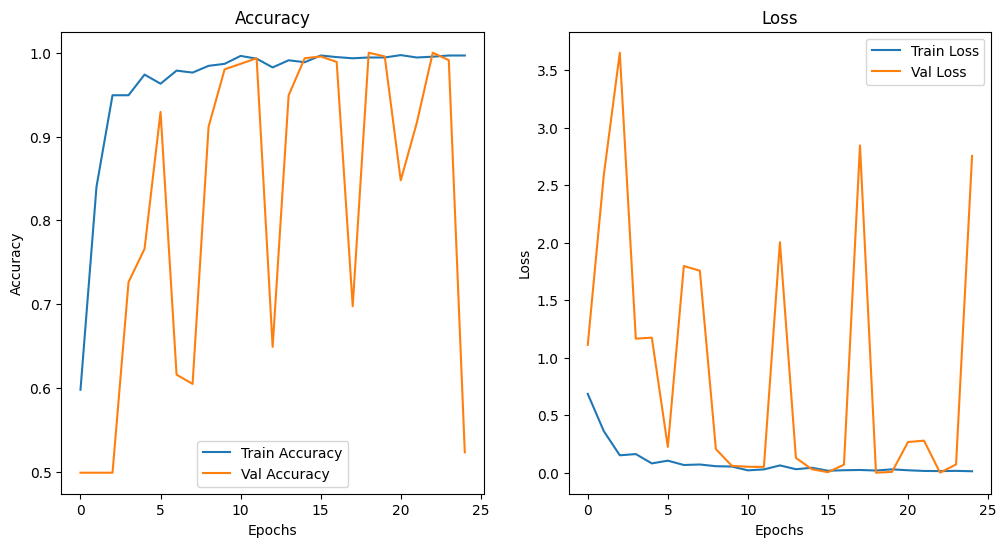

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# # Save the model
# model.save('/content/drive/MyDrive/Audio_Forensics_Models/asvpoof_model.h5')

In [ ]:
# Predict function to classify a new audio file
def audio_to_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

def predict_audio(file_path):
    mel_spectrogram = audio_to_mel_spectrogram(file_path)
    mel_resized = librosa.util.fix_length(mel_spectrogram, size=128, axis=1)
    mel_resized = cv2.resize(mel_resized, (128, 128))
    mel_resized = mel_resized.reshape(1, 128, 128, 1)
    prediction = model.predict(mel_resized)
    predicted_class = 'Fake' if prediction > 0.5 else 'Real'
    return predicted_class

# Upload a new file for prediction
uploaded = files.upload()
new_file = next(iter(uploaded))

# Make a prediction for the uploaded file
prediction = predict_audio(new_file)
print(f"Prediction for {new_file}: {prediction}")

Saving fake2_5.wav to fake2_5.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for fake2_5.wav: Real
